In [35]:

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100




In [38]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [28]:
from functools import partial
from scipy.stats import norm
def schon_basis(x):
    return x 

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=0.3):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)


#expand = expand_polynomial
expand = expand_gaussian

In [39]:
#to check the basis function test it with values
expand_polynomial(np.array([0.5, 1.5]), degree=3)

array([[0.5  , 0.25 , 0.125],
       [1.5  , 2.25 , 3.375]])

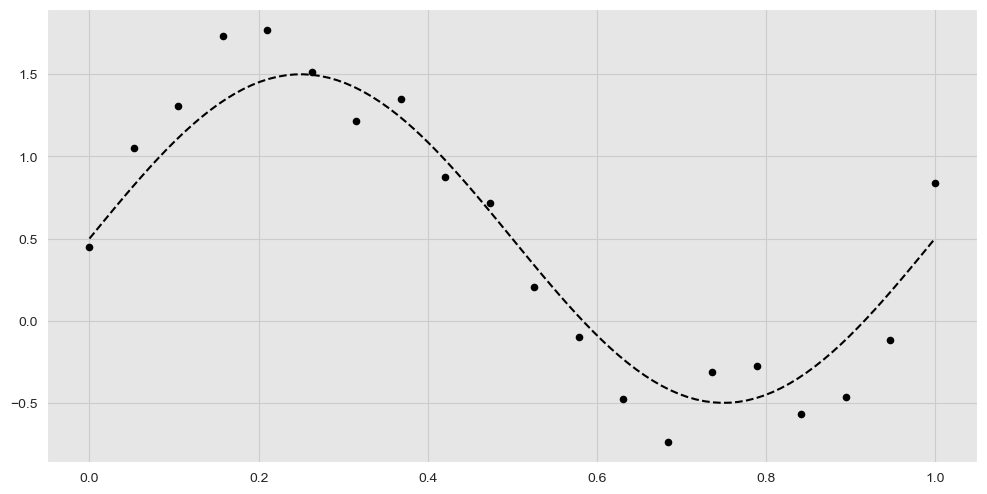

In [40]:
###Fake data generation
def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

# Number of samples
N = 20

# Constant noise 
noise = 0.3

# Noisy samples 
x = np.linspace(0, 1, N, dtype=np.float32)
t = f(x, noise=noise)

# Noise-free ground truth 
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

plot_data(x, t)
plot_truth(x_test, y_true)

In [41]:
from theano import shared

Phi = expand(x)
Phi_shared = shared(Phi)

with pm.Model() as model:
    w_0 = pm.Normal('w_0', mu=0, sigma=10)
    w_r = pm.Normal('w_r', mu=0, sigma=10, shape=Phi.shape[1])

    mu = w_0 + w_r.dot(Phi_shared.T)
    
    t_obs = pm.Normal('t_obs', mu=mu, sigma=noise, observed=t)

In [42]:
with model:
    trace = pm.sample()

/var/folders/v1/58yl0t_n2ng9vz587pfjhtpc0000gn/T/ipykernel_33687/366605620.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_r, w_0]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


/var/folders/v1/58yl0t_n2ng9vz587pfjhtpc0000gn/T/ipykernel_33687/3892976860.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, compact=False)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'w_0'}>,
        <AxesSubplot:title={'center':'w_0'}>],
       [<AxesSubplot:title={'center':'w_r\n0'}>,
        <AxesSubplot:title={'center':'w_r\n0'}>],
       [<AxesSubplot:title={'center':'w_r\n1'}>,
        <AxesSubplot:title={'center':'w_r\n1'}>],
       [<AxesSubplot:title={'center':'w_r\n2'}>,
        <AxesSubplot:title={'center':'w_r\n2'}>]], dtype=object)

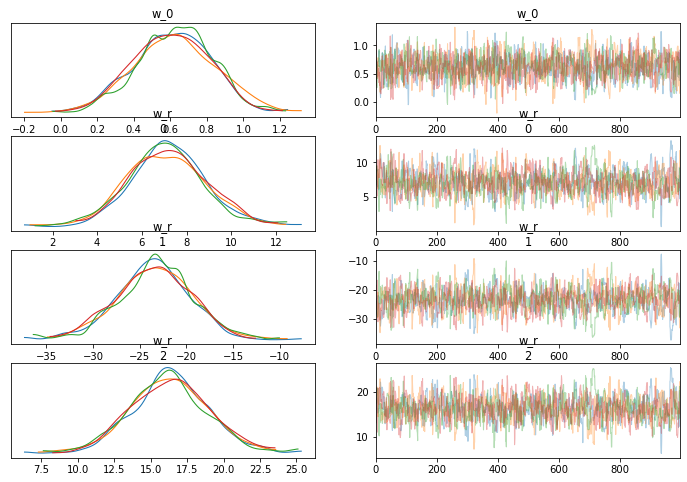

In [24]:
pm.traceplot(trace, compact=False)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/sabazamankhani/miniforge3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'w_r\n0'}>,
        <AxesSubplot:title={'center':'w_r\n1'}>,
        <AxesSubplot:title={'center':'w_r\n2'}>],
       [<AxesSubplot:title={'center':'w_r\n3'}>,
        <AxesSubplot:title={'center':'w_r\n4'}>,
        <AxesSubplot:title={'center':'w_r\n5'}>],
       [<AxesSubplot:title={'center':'w_r\n6'}>,
        <AxesSubplot:title={'center':'w_r\n7'}>,
        <AxesSubplot:title={'center':'w_r\n8'}>]], dtype=object)

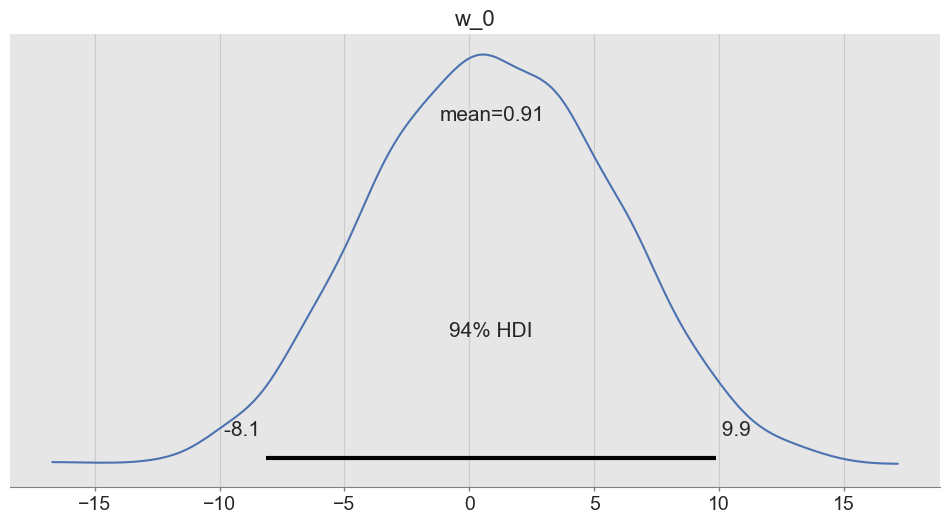

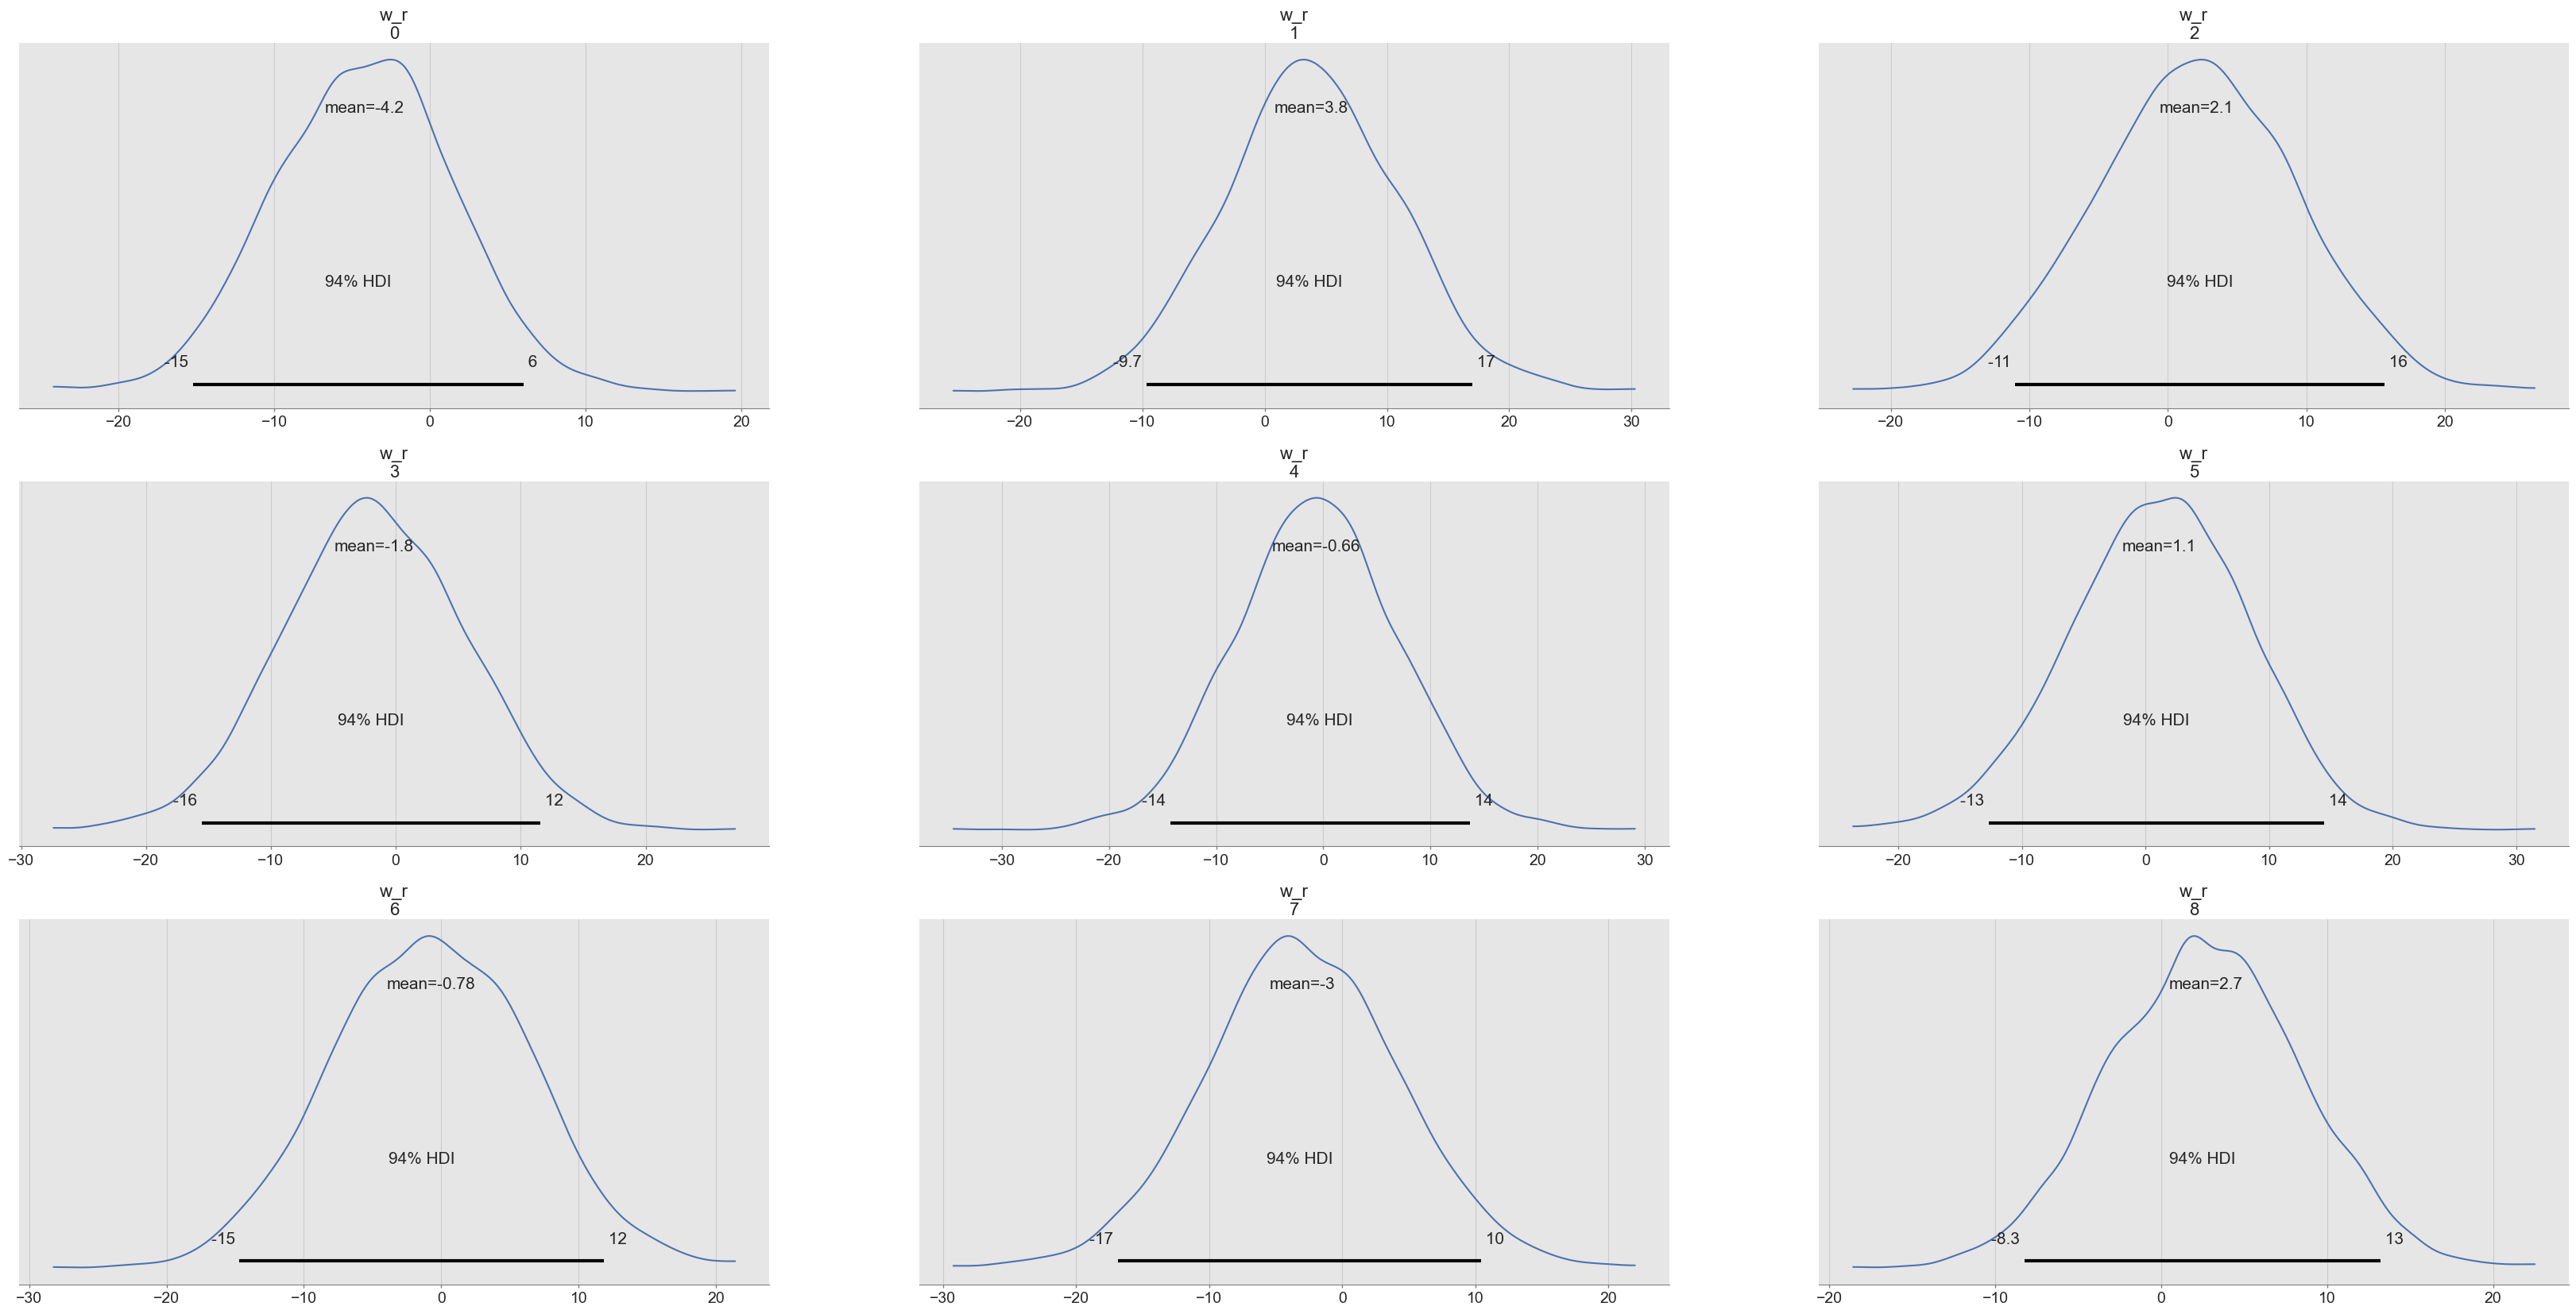

In [43]:
pm.plot_posterior(trace, var_names="w_0")
pm.plot_posterior(trace, var_names="w_r")

In [44]:
#posterior predictive samples for a separate test set 
Phi_shared.set_value(expand(x_test))
predictive_samples = pm.sample_posterior_predictive(trace, model=model, samples=5000)['t_obs']

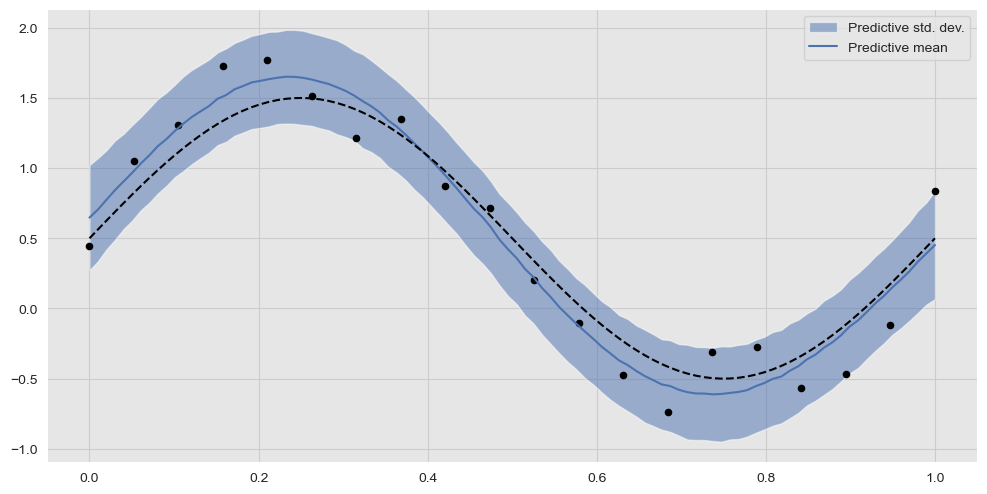

In [45]:
m = np.mean(predictive_samples, axis=0)
s = np.std(predictive_samples, axis=0)

plt.fill_between(x_test, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x_test, m, label='Predictive mean')

plot_data(x, t)
plot_truth(x_test, y_true, label=None)

plt.legend()

